In [10]:
# imports for the notebook
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration and Modification

In [ ]:


# read in dinosaur.csv and modify input so that the list only contains lowercase dinosaur names with no whitespace
dinosaur_csv = pd.read_csv("dinosaur.csv")
dinosaurs = dinosaur_csv['Name'].tolist()
dinosaurs = [d.lower().strip() for d in dinosaurs]
dinosaurs[:5]

In [12]:
len(dinosaurs) # number of dinosaur names

1152

In [13]:
min(len(d) for d in dinosaurs) # smallest dinosaur name

3

In [14]:
max(len(d) for d in dinosaurs) # largest dinosaur name

23

In [15]:
N = torch.zeros((27,27), dtype=torch.int32) # create a 27x27 tensor to hold bigram counts

chars = sorted(list(set(''.join(dinosaurs)))) # sort letters alphabetically with no repeating characters

stoi = {s:i+1 for i,s in enumerate(chars)} # create a string to integer mapping
stoi['.'] = 0 # add '.' character as special start and end character
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [16]:
itos = {i:s for s,i in stoi.items()} # create an integer to string mapping
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [17]:
# manual count of frequency of bigrams
for d in dinosaurs:
    
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        N[idx1,idx2] += 1 # add 1 to count at the [idx1, idx2] index within the 27x27 tensor N

(-0.5, 26.5, 26.5, -0.5)

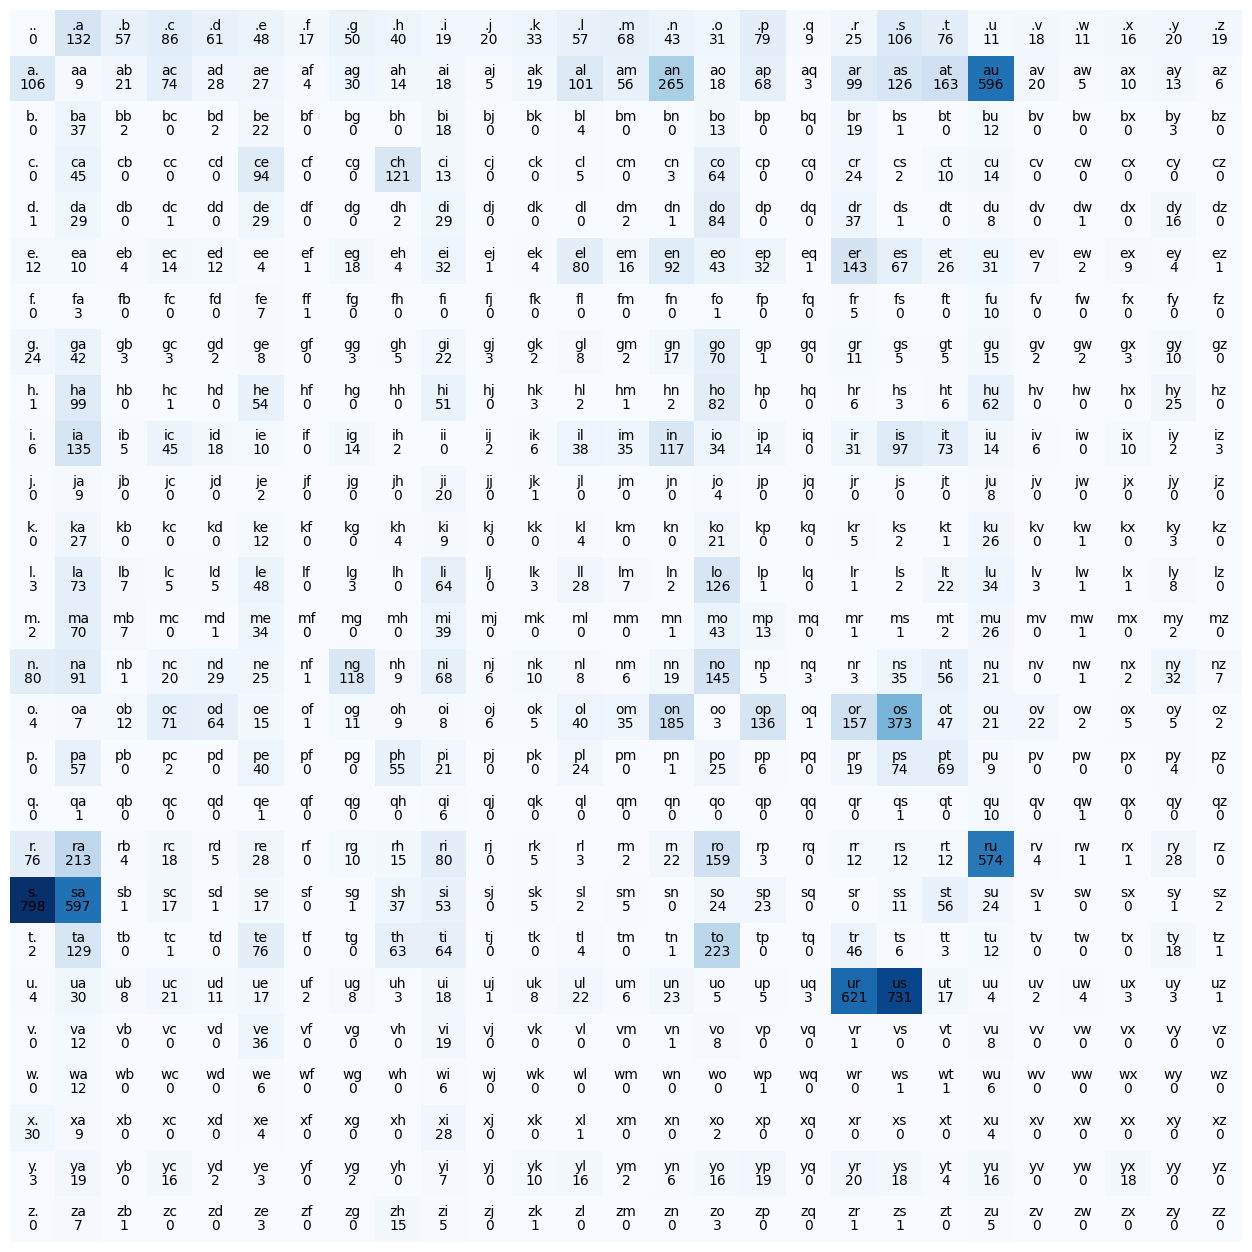

In [18]:
# plot bigram combinations with counts
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color="black")
        plt.text(j,i,N[i,j].item(),ha="center",va="top",color="black")
plt.axis('off')

# Bigram Models (Counting and Linear Layer Implementations)

In [19]:
P = (N+1).float() # Add smoothing for counts of 0 and convert ints to floats
P = P / P.sum(1, keepdim=True) # get probabilites for each bigram

In [20]:
# create a generator for reproducability
g = torch.Generator().manual_seed(42)

# sample based of probability tensor P
for i in range(5):
    
    idx = 0 # start at '.' character
    out = [] # output array
    
    while True:
        p = P[idx] # get 1 dimensional tensor probabilities from P
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # pull one index using p
        out.append(itos[idx]) # append the character using the integer to string mapping
        
        # if the idx is 0, which means character '.' then end the word
        if idx == 0:
            break
    
    print(''.join(out)) # print out word

yrosathas.
binodlogothodoponys.
trurus.
chenoenausapatoiauraukeles.
long.


In [21]:
log_likelihood = 0.0
count = 0

# get loss from manual counting
for d in dinosaurs:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        
        prob = P[idx1, idx2] # get probability of bigram from 2D probability tensor P
        logprob = torch.log(prob) # convert the probability using log
        log_likelihood += logprob # sum up all of the logs: log(a*b*c) = log(a) + log(b) + log(c)
        count += 1 # keep count to get average
        
print(f'Log Likelihood: {log_likelihood.item()}')
neg_log_likelihood = -log_likelihood
print(f'Negative Log Likelihood: {neg_log_likelihood.item()}')
print(f'Avg. Negative Log Likelihood: {neg_log_likelihood/count}')

Log Likelihood: -31859.572265625
Negative Log Likelihood: 31859.572265625
Avg. Negative Log Likelihood: 2.144559144973755


In [22]:
xs, ys = [],[]

# create dataset out of dinosaur names
for d in dinosaurs[:1]:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        
        xs.append(idx1) # append first letter index to xs (features)
        ys.append(idx2) # append second letter index to ys (labels)
        
# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

In [25]:
negative_log_likelihood = torch.zeros(9)
for i in range(9):
    x = xs[i].item()
    y = ys[i].item()
    
    print(f'Bigram {i+1}: {itos[x]} {itos[y]}')
    print(f'Probabilities: {P[i]}')
    print(f'True label: {y}')
    
    p = P[i, y]
    print(f'Probability of true label: {p.item()}')
    
    logp = torch.log(p)
    print(f'Log Likelihood: {logp.item()}')
    
    nll = -logp
    print(f'Negative Log Likelihood: {nll.item()}\n')
    negative_log_likelihood[i] = nll
    
print('==============================')
print(f'Avg. Negative Log Likelihood: {negative_log_likelihood.mean().item()}')
    
    

Bigram 1: . a
Probabilities: tensor([0.0008, 0.1128, 0.0492, 0.0738, 0.0526, 0.0416, 0.0153, 0.0433, 0.0348,
        0.0170, 0.0178, 0.0288, 0.0492, 0.0585, 0.0373, 0.0271, 0.0679, 0.0085,
        0.0221, 0.0908, 0.0653, 0.0102, 0.0161, 0.0102, 0.0144, 0.0178, 0.0170])
True label: 1
Probability of true label: 0.11280746757984161
Log Likelihood: -2.182072639465332
Negative Log Likelihood: 2.182072639465332

Bigram 2: a a
Probabilities: tensor([0.0554, 0.0052, 0.0114, 0.0388, 0.0150, 0.0145, 0.0026, 0.0161, 0.0078,
        0.0098, 0.0031, 0.0104, 0.0528, 0.0295, 0.1378, 0.0098, 0.0357, 0.0021,
        0.0518, 0.0658, 0.0849, 0.3092, 0.0109, 0.0031, 0.0057, 0.0073, 0.0036])
True label: 1
Probability of true label: 0.00517866387963295
Log Likelihood: -5.263208389282227
Negative Log Likelihood: 5.263208389282227

Bigram 3: a r
Probabilities: tensor([0.0063, 0.2375, 0.0188, 0.0063, 0.0188, 0.1437, 0.0063, 0.0063, 0.0063,
        0.1187, 0.0063, 0.0063, 0.0312, 0.0063, 0.0063, 0.0875, 0.0063,

In [26]:
# create generator for reproducability
g = torch.Generator().manual_seed(42)

# W is a 27x27 tensor of random values. This will be the weights for the model
W = torch.randn((27,27), generator=g, requires_grad=True)

In [27]:
xenc = F.one_hot(xs, num_classes=27).float() # one hot encoding of xs (features)
logits = xenc @ W # log counts based on matrix multiplication between weights and one hot encoding
counts = logits.exp() # counts are made to be always positive
probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows
loss = -probs[torch.arange(9), ys].log().mean() # loss calculated from ys along with a regressor
print(loss.item())

3.3371410369873047


In [28]:
xs, ys = [],[]

# create dataset out of dinosaur names
for d in dinosaurs:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        
        xs.append(idx1) # append first letter index to xs (features)
        ys.append(idx2) # append second letter index to ys (labels)
        
# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

# count total number of bigrams
num = xs.nelement()
print(f'Num examples: {num}')

# create generator for reproducability
g = torch.Generator().manual_seed(42)

# W is a 27x27 tensor of random values. This will be the weights for the model
W = torch.randn((27,27), generator=g, requires_grad=True)

Num examples: 14856


In [29]:
# gradient descent
loss = 0.0
for i in range(1000):
    
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # one hot encoding of xs (features)
    logits = xenc @ W # log counts based on matrix multiplication between weights and one hot encoding
    
    # Softmax function
    counts = logits.exp() # counts are made to be always positive
    probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows
    
    # loss calculated from ys along with a regressor
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

    # backpropogation
    W.grad=None
    loss.backward()

    W.data += -50 * W.grad
print(loss.item())

2.191737174987793


In [30]:
#create generator for reproducability
g = torch.Generator().manual_seed(42)

# sample from model
for i in range(5):
    out = [] # output array
    idx = 0 # start at '.' character
    while True:
        xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float() # one hot encoding of idx (features)
        logits = xenc @ W # log counts based on weights and one hot encodings
        counts = logits.exp() # counts are made to be always positive
        p = counts / counts.sum(1, keepdims=True)# probabilities based on rows
        
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # pull one index using p
        out.append(itos[idx]) # append character using integer to string mapping
        
        # if the idx is 0, which means character '.' then end the word
        if idx == 0:
            break
    print(''.join(out))

yros.
atheochenologothodoponys.
trus.
dachenoenaus.
patoiauraukeles.


# Trigram Implementation

In [31]:
dinosaurs[:5]

['aardonyx', 'abelisaurus', 'abrictosaurus', 'abrosaurus', 'abydosaurus']

In [32]:
xs, ys = [],[]

# create dataset out of dinosaur names
for d in dinosaurs:
    chs = ['.', '.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary
        
        xs.append((idx1,idx2)) # append first letter index to xs (features)
        ys.append(idx3) # append second letter index to ys (labels)
        
# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

# count total number of bigrams
num = xs.shape[0]
print(f'Num examples: {num}')

# create generator for reproducability
g = torch.Generator().manual_seed(42)

# W is a 27x27 tensor of random values. This will be the weights for the model
W = torch.randn((27*2,27), generator=g, requires_grad=True)

Num examples: 14856


In [33]:
# gradient descent
loss=0.0
for i in range(1000):
    
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # one hot encoding of xs (features)
    logits = xenc.view(-1,27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding
        
    # Softmax function
    counts = logits.exp() # counts are made to be always positive
    probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows    
    # loss calculated from ys along with a regressor
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()

    # backpropogation
    W.grad=None
    loss.backward()

    W.data += -50 * W.grad
print(loss.item())

1.9011883735656738


In [34]:
for i in range(5):
    out = [] # output array
    idx1 = 0 # start at '.' character
    idx2 = 0 # start at '.' character
    while True:
        xenc = F.one_hot(torch.tensor([idx1, idx2]), num_classes=27).float() # one hot encoding of idx (features)
        logits = xenc.view(-1,27*2) @ W # log counts based on weights and one hot encodings
        counts = logits.exp() # counts are made to be always positive
        p = counts / counts.sum(1, keepdims=True)# probabilities based on rows
        
        idx1 = idx2
        idx2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # pull one index using p
        out.append(itos[idx2]) # append character using integer to string mapping
        
        # if the idx is 0, which means character '.' then end the word
        if idx2 == 0:
            break
    print(''.join(out))

zinova.
lbiteps.
peleanithiaus.
acordayrchus.
chostacrus.


#### As we can see above, the Trigram model achieves a much lower loss than the Bigram model with the same Regressor and Learning Rate. This insight is not unexpected as the Trigram model recieves more inputs to tune the weights more accurately than the Bigram model.

# Dataset Splitting

In [66]:
# splitting dataset into train(80%), development(10%), and test(10%) sets
g = torch.Generator().manual_seed(42)
train, dev, test = torch.utils.data.random_split(dinosaurs, [0.8, 0.1, 0.1], generator=g)

In [67]:
# function for bigram model training
W = torch.randn((27,27), generator=g, requires_grad=True)
def bigram(xs, ys, num, iters=1000, regressor=0.01, lr=0.1):
    loss = 0.0    
    for i in range(iters):

        # forward pass
        xenc = F.one_hot(xs, num_classes=27).float() # one hot encoding of xs (features)
        # xenc = W[]
        logits = xenc @ W # log counts based on matrix multiplication between weights and one hot encoding

         # softmax function
         # counts = logits.exp() # counts are made to be always positive
         # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys along with a regressor
        # loss = -probs[torch.arange(num), ys].log().mean() + regressor*(W**2).mean()
        loss = F.cross_entropy(logits, ys) + regressor*(W**2).mean()

        # backpropogation
        W.grad=None
        loss.backward()

        W.data += -lr * W.grad
    return loss

In [68]:
# training Bigram model on train set
xs, ys = [],[]

for d in train:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        
        xs.append(idx1) # append first letter index to xs (features)
        ys.append(idx2) # append second letter index to ys (labels)
        
# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

# count total number of bigrams
num = xs.nelement()
print(f'Num examples: {num}')

loss = bigram(xs, ys, num, lr=50)
print("Loss: ", loss.item())

Num examples: 11909
Loss:  2.185251474380493


In [76]:
# evaluating Bigram model on development and test sets
lossi = []

for d in dev:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary

        xenc = F.one_hot(torch.tensor([idx1]), num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc @ W # log counts based on matrix multiplication between weights and one hot encoding
        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys
        # lossi.append(F.cross_entropy(logits, torch.tensor([idx2])))
        lossi.append(F.cross_entropy(logits, torch.tensor([idx2])))
        
print("Dev loss: ", torch.tensor(lossi).mean().item())

lossi = []
for d in test:
    chs = ['.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary

        xenc = F.one_hot(torch.tensor([idx1]), num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc @ W # log counts based on matrix multiplication between weights and one hot encoding
        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys
        # lossi.append(-probs[0, torch.tensor([idx2])].log())
        lossi.append(F.cross_entropy(logits, torch.tensor([idx2])))
        
print("Test loss: ", torch.tensor(lossi).mean().item())

Dev loss:  2.2230563163757324
Test loss:  2.2546446323394775


### Above we can see the development and test sets perform relatively similar to the train set

In [77]:
W = torch.randn((27*2,27), generator=g, requires_grad=True)

def trigram(xs, ys, num, iters=1000, regressor=0.01, lr=0.1):
    loss=0.0
    for i in range(iters):

        # forward pass
        xenc = F.one_hot(xs, num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc.view(-1,27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding

        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows   
        
        # loss calculated from ys along with a regressor
        # loss = -probs[torch.arange(num), ys].log().mean() + regressor*(W**2).mean()
        loss = F.cross_entropy(logits, ys) + regressor*(W**2).mean()
        

        # backpropogation
        W.grad=None
        loss.backward()

        W.data += -lr * W.grad
    return loss

In [78]:
# training Trigram model on train set
xs, ys = [],[]

for d in train:
    chs = ['.', '.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary
        
        xs.append((idx1,idx2)) # append first letter index to xs (features)
        ys.append(idx3) # append second letter index to ys (labels)
        
# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

# count total number of trigrams
num = xs.shape[0]
print(f'Num examples: {num}')

loss = trigram(xs, ys, num, lr=50)
print("Loss: ", loss.item())

Num examples: 11909
Loss:  1.88483726978302


In [79]:
# evaluating Trigram model on development and test sets
lossi = []

for d in dev:
    chs = ['.','.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary

        xenc = F.one_hot(torch.tensor((idx1, idx2)), num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc.view(-1, 27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding
        
        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys
        # lossi.append(-probs[0, idx3].log())
        lossi.append(F.cross_entropy(logits, torch.tensor([idx3])))
        
        
print("Dev loss: ", torch.tensor(lossi).mean().item())

lossi = []
for d in test:
    chs = ['.','.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names
    
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary

        xenc = F.one_hot(torch.tensor((idx1, idx2)), num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc.view(-1, 27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding
        
        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys
        # lossi.append(-probs[0, idx3].log())
        lossi.append(F.cross_entropy(logits, torch.tensor([idx3])))
        
print("Test loss: ", torch.tensor(lossi).mean().item())

Dev loss:  1.9921818971633911
Test loss:  2.0025579929351807


### Again we can see the development and test set losses are relatively similar to the train set loss when using the Trigram model. It is important to note that although the losses are higher than the train set, the Trigram model is still performing marginally better than the Bigram model

# Model Smoothing

In [80]:
# smoothing the model using different regressor strengths
smoothness = np.linspace(0, 1, 10)

for s in smoothness:
    W = torch.randn((27*2,27), generator=g, requires_grad=True)
    
    xs, ys = [],[]
    for d in train:
        chs = ['.', '.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names

        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            idx1 = stoi[ch1] # get index of first character from stoi dictionary
            idx2 = stoi[ch2] # get index of second character from stoi dictionary
            idx3 = stoi[ch3] # get index of third character from stoi dictionary

            xs.append((idx1,idx2)) # append first letter index to xs (features)
            ys.append(idx3) # append second letter index to ys (labels)

    # convert xs and ys to tensors
    xs = torch.tensor(xs) 
    ys = torch.tensor(ys)

    # count total number of trigrams
    num = xs.shape[0]

    loss = trigram(xs, ys, num, regressor=s, lr=50)
    print("TRAIN: Smoothness: ", s, "Loss: ", loss.item())
    
    lossi = []

    for d in dev:
        chs = ['.','.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names

        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            idx1 = stoi[ch1] # get index of first character from stoi dictionary
            idx2 = stoi[ch2] # get index of second character from stoi dictionary
            idx3 = stoi[ch3] # get index of third character from stoi dictionary

            xenc = F.one_hot(torch.tensor((idx1, idx2)), num_classes=27).float() # one hot encoding of xs (features)
            logits = xenc.view(-1, 27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding
            # softmax function
            # counts = logits.exp() # counts are made to be always positive
            # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

            # loss calculated from ys
            # lossi.append(-probs[0, idx3].log())
            lossi.append(F.cross_entropy(logits, torch.tensor([idx3])))
            
        
    print("DEV: Smoothness: ", s, "Loss: ", torch.tensor(lossi).mean().item(),"\n")

TRAIN: Smoothness:  0.0 Loss:  1.865308165550232
DEV: Smoothness:  0.0 Loss:  1.9999617338180542 

TRAIN: Smoothness:  0.1111111111111111 Loss:  1.9698565006256104
DEV: Smoothness:  0.1111111111111111 Loss:  1.9976199865341187 

TRAIN: Smoothness:  0.2222222222222222 Loss:  2.0240635871887207
DEV: Smoothness:  0.2222222222222222 Loss:  2.01432728767395 

TRAIN: Smoothness:  0.3333333333333333 Loss:  2.065512180328369
DEV: Smoothness:  0.3333333333333333 Loss:  2.030717372894287 

TRAIN: Smoothness:  0.4444444444444444 Loss:  2.099963426589966
DEV: Smoothness:  0.4444444444444444 Loss:  2.0462043285369873 

TRAIN: Smoothness:  0.5555555555555556 Loss:  2.129803419113159
DEV: Smoothness:  0.5555555555555556 Loss:  2.0607903003692627 

TRAIN: Smoothness:  0.6666666666666666 Loss:  2.156306028366089
DEV: Smoothness:  0.6666666666666666 Loss:  2.0745656490325928 

TRAIN: Smoothness:  0.7777777777777777 Loss:  2.180250644683838
DEV: Smoothness:  0.7777777777777777 Loss:  2.0876245498657227 


### As seen above, it is clear that for this dataset the weaker the stength of the regressor, the smaller the loss is. But a little bit of strength does help as the 0.1 strength is better than 0.

In [82]:
# Using the best setting of the regressor strength for the test set
s = 0.1

W = torch.randn((27*2,27), generator=g, requires_grad=True)

xs, ys = [],[]
for d in train:
    chs = ['.', '.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names

    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary

        xs.append((idx1,idx2)) # append first letter index to xs (features)
        ys.append(idx3) # append second letter index to ys (labels)

# convert xs and ys to tensors
xs = torch.tensor(xs) 
ys = torch.tensor(ys)

# count total number of trigrams
num = xs.shape[0]

loss = trigram(xs, ys, num, regressor=s, lr=50)
print("TRAIN: Smoothness: ", s, "Loss: ", loss.item())

lossi = []

for d in test:
    chs = ['.','.'] + list(d) + ['.'] # add '.' characters to beginning and end of dinosaur names

    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1 = stoi[ch1] # get index of first character from stoi dictionary
        idx2 = stoi[ch2] # get index of second character from stoi dictionary
        idx3 = stoi[ch3] # get index of third character from stoi dictionary

        xenc = F.one_hot(torch.tensor((idx1, idx2)), num_classes=27).float() # one hot encoding of xs (features)
        logits = xenc.view(-1, 27*2) @ W # log counts based on matrix multiplication between weights and one hot encoding
        # softmax function
        # counts = logits.exp() # counts are made to be always positive
        # probs = counts / counts.sum(1, keepdims=True) # probabilities based on rows

        # loss calculated from ys
        # lossi.append(-probs[0, idx3].log())
        lossi.append(F.cross_entropy(logits, torch.tensor([idx3])))
        

print("TEST: Smoothness: ", s, "Loss: ", torch.tensor(lossi).mean().item(),"\n")

TRAIN: Smoothness:  0.1 Loss:  1.9631993770599365
TEST: Smoothness:  0.1 Loss:  2.0116167068481445 



### A pretty good loss of 2.01 from the test set after training with the 0.1 regressor.